# Investing with SentDex
https://pythonprogramming.net/data-acquisition-machine-learning/


   

In [1]:
import pandas as pd
import os
import time
from datetime import datetime
from tqdm import tqdm

from time import mktime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use("dark_background")

import re

path=r"D:/My Computer/DATA/intraQuarter"


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 23.76it/s]

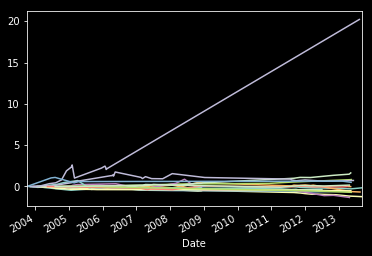

TotalDebtEquitymrq.csv


In [4]:
# Selecting the appropriate files
def Key_Stats(gather="Total Debt/Equity (mrq)"):
    statspath = path+'/_KeyStats' # deeper folder
    stock_list = [x[0] for x in os.walk(statspath)] 
    # 0th elements are the file path with name
    # print(stock_list)
    df = pd.DataFrame(columns = ['Date',
                                 'Unix',
                                 'Ticker',
                                 'DE Ratio',
                                 'Price',
                                 'stock_p_change',
                                 'SP500',
                                 'sp500_p_change',
                                 'Difference'])
    
    sp500_df = pd.DataFrame.from_csv("^GSPC.csv")
    #sp500_date['date'] = sp500_date.index
    #sp500_date.reset_index()
    
    ticker_list= []

    for each_dir in tqdm(stock_list[1:20]): 
        #this ignores the 0th element, which is folder path
        each_file = os.listdir(each_dir)
        #each folder's individualized path to proceed with parsing
        ticker = each_dir.split("\\")[1]
        ticker_list.append(ticker)
        
        starting_stock_value = False
        starting_sp500_value = False
        
        
        if len(each_file) > 0:
            # doesn't attempt empty files
            for file in each_file:
                date_stamp = datetime.strptime(file, '%Y%m%d%H%M%S.html')
                #parses the name into date
                unix_time = time.mktime(date_stamp.timetuple())
                # transforms into unix time
                #print(date_stamp, unix_time)
                full_file_path = each_dir+'/'+file
                #print(full_file_path)
                #print(each_dir)
                source = open(full_file_path,'r').read()
                #print(source)
                try:
                    try:
                        value = float(source.split(gather+':</td><td class="yfnc_tabledata1">')[1].split('</td>')[0])
                    #except:
                    except:
                        value = float(source.split(gather+':</td>\n<td class="yfnc_tabledata1">')[1].split('</td>')[0])
                        #print(str(e),ticker,file)
                        # Check where bug is at!
                    
                    # Try because not all companies will have the DE ratio, so this ignores those
                    #value = float(source.split(gather+':</td><td class="yfnc_tabledata1">')[1].split('</td>')[0])
                    # Errors emerged when table format changed, so created try/except statement to handle it
                    # Float
                    # Dives into the source of crawled htlm, and selects data between both splits
                    try:
                        sp500_date = datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d')
                        # Transform ticket date into S&P equivalent
                        row = sp500_df[(sp500_df.index == sp500_date)]
                        #Apply the S&P row that equates the ticket time
                        sp500_value = float(row["Adj Close"])
                        #Extract price value
                    except:
                        sp500_date = datetime.fromtimestamp(unix_time-259200).strftime('%Y-%m-%d')
                        row = sp500_df[(sp500_df.index == sp500_date)]
                        sp500_value = float(row["Adj Close"])
                    
                    try:
                        stock_price = float(source.split('</small><big><b>')[1].split('</b></big>')[0])
                        #print("stock_price:",stock_price,"ticker:", ticker)
                    except:
                        # <span id="yfs_l10_aa">12.04</span>
                        try:
                            stock_price = (source.split('</small><big><b>')[1].split('</b></big>')[0])
                            stock_price = re.search(r'(\d{1,8}\.\d{1,8})', stock_price) 
                            #1-8 digits . (\to have symbol not expression) 1-8 digit
                            stock_price= float(stock_price.group(1))
                            #print(stock_price)
                        except:
                            try:
                                stock_price = (source.split('<span class="time_rtq_ticker">')[1].split('</span>')[0])
                                #print(stock_price)
                                stock_price = re.search(r'(\d{1,8}\.\d{1,8})', stock_price)
                                stock_price = float(stock_price.group(1))
                                #print(stock_price)
                            except:
                                
                                print('wtf stock price lol',ticker,file, value)
                                time.sleep(5)

                    if not starting_stock_value: #If false
                        starting_stock_value = stock_price
                    if not starting_sp500_value: #If false
                        starting_sp500_value = sp500_value
                    
                    
                    stock_p_change= ((stock_price - starting_stock_value) / starting_stock_value)
                    sp500_p_change= ((sp500_value - starting_sp500_value) / starting_sp500_value)
                    
                    difference = stock_p_change-sp500_p_change
                    
                    df = df.append({'Date':date_stamp,
                                    'Unix':unix_time,
                                    'Ticker':ticker,
                                    'DE Ratio':value,
                                    'Price':stock_price,
                                    'stock_p_change':stock_p_change,
                                    'SP500':sp500_value,
                                    'sp500_p_change':sp500_p_change,
                                    'Difference':difference}, ignore_index = True)
                    # Append a Dictionary of VALUE: Must ignore index
                except Exception as e:
                    pass
                    #print(str(e))
                
                #print(ticker+":",value) # dont need this once results are saved to DF
                
    for each_ticker in ticker_list:
        try:
            plot_df= df[(df['Ticker']== each_ticker)]
            plot_df = plot_df.set_index(['Date'])
            
            plot_df['Difference'].plot(label=each_ticker)
        except:
            pass
    
    plt.show()
    
    save = gather.replace(' ','').replace(')','').replace('(','').replace('/','')+('.csv')
    # removes punctuation and spaced from "Total Debt/Equity (mrq)
    print(save)
    df.to_csv(save)
    
Key_Stats()

In [ ]:
print("hi")